In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 37.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pyli

In [2]:
!nvidia-smi

Mon Nov 24 06:50:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
import evaluate

DATA_PATH = "/kaggle/input/classification-data/enron_spam_data.csv"
MODEL_NAME = "distilbert-base-uncased"
SEED = 66

FEW_SHOT_SIZES = [4, 8, 16, 32, 64, 128]  # set different few-shot sizes for scaling experiments

torch.manual_seed(SEED)
np.random.seed(SEED)

# ======================
print("📥 Loading raw dataset...")
df = pd.read_csv(DATA_PATH)
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

print("🧹 Preprocessing dataset...")

def prepare_label(example):
    example["label"] = 1 if example["Spam/Ham"].lower() == "spam" else 0
    return example

dataset = dataset.map(prepare_label)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    messages = [msg if msg is not None else "" for msg in examples["Message"]]
    return tokenizer(messages, truncation=True, padding="max_length", max_length=512)

# Filter out empty or None messages
dataset = dataset.filter(lambda x: x["Message"] is not None and len(str(x["Message"]).strip()) > 0)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

print(f"✅ Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

FEW_SHOT_SIZES = [n for n in FEW_SHOT_SIZES if n <= len(train_dataset)]
if not FEW_SHOT_SIZES:
    FEW_SHOT_SIZES = [min(16, len(train_dataset))]

print(f"🔍 Will run few-shot experiments with sizes: {FEW_SHOT_SIZES}")

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

id2label = {0: "HAM", 1: "SPAM"}
label2id = {"HAM": 0, "SPAM": 1}

# ====================== 2. Zero-shot: raw pre-trained model

print("\n" + "="*60)
print("🧪 ZERO-SHOT EXPERIMENT (no training)")
print("="*60)

zero_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

zero_trainer = Trainer(
    model=zero_model,
    args=TrainingArguments(
        output_dir="/kaggle/working/tmp_zero",
        per_device_eval_batch_size=64,
        report_to="none"
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

zero_result = zero_trainer.evaluate()
print(f"✅ Zero-shot Accuracy: {zero_result['eval_accuracy']:.4f}")

# ====================== 3. Few-shot scaling experiments


print("\n" + "="*60)
print("📈 FEW-SHOT SCALING EXPERIMENTS")
print("="*60)

results = {"zero_shot": zero_result['eval_accuracy']}

for n_samples in FEW_SHOT_SIZES:
    print(f"\n👉 Training with {n_samples} samples (seed={SEED})...")

    # Sample subset (fixed seed for reproducibility)
    small_train = train_dataset.shuffle(seed=SEED).select(range(n_samples))

    # Fresh model each time
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"/kaggle/working/new_fewshot_{n_samples}",
        learning_rate=2e-4,
        per_device_train_batch_size=min(64, n_samples),
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        fp16=True,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=1000,
        report_to="none",
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_res = trainer.evaluate()
    acc = eval_res['eval_accuracy']
    results[n_samples] = acc
    print(f"✅ Accuracy with {n_samples} samples: {acc:.4f}")

# ======================   4. Full fine-tuning: train on entire training set
print("\n" + "="*60)
print("🎯 FULL FINE-TUNING EXPERIMENT")
print("="*60)

full_train_size = len(train_dataset)
print(f"👉 Training with FULL dataset ({full_train_size} samples)...")

full_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

full_training_args = TrainingArguments(
    output_dir="/kaggle/working/full_finetune",
    learning_rate=2e-5,          # smaller learning rate suitable for full fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    report_to="none",
    seed=SEED,
)

full_trainer = Trainer(
    model=full_model,
    args=full_training_args,
    train_dataset=train_dataset,   # full dataset
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

full_trainer.train()
full_result = full_trainer.evaluate()
full_acc = full_result['eval_accuracy']
results["full"] = full_acc
print(f"✅ Full fine-tuning Accuracy: {full_acc:.4f}")


# ======================
# 4. Save final scaling results
# ======================
print("\n" + "="*60)
print("📊 FINAL SCALING RESULTS (Project A Advanced Direction #2)")
print("="*60)

data_rows = [{"Setting": "Zero-shot", "Samples": 0, "Accuracy": results["zero_shot"]}]
for n in FEW_SHOT_SIZES:
    data_rows.append({
        "Setting": f"Few-shot ({n})",
        "Samples": n,
        "Accuracy": results[n]
    })
data_rows.append({
    "Setting": "Full fine-tuning",
    "Samples": len(train_dataset),
    "Accuracy": results["full"]
})

df_results = pd.DataFrame(data_rows)
print(df_results.to_string(index=False))

# Save to CSV
output_file = "/kaggle/working/project_a_scaling_resultsnew.csv"
df_results.to_csv(output_file, index=False)
print(f"\n✅ Scaling analysis results saved to '{output_file}'")
print("💡 Use this to plot accuracy vs. number of training samples (log scale recommended).")

2025-11-24 06:50:43.880675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763967044.068941      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763967044.122686      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

📥 Loading raw dataset...
🧹 Preprocessing dataset...


Map:   0%|          | 0/26972 [00:00<?, ? examples/s]

Map:   0%|          | 0/6744 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Filter:   0%|          | 0/26972 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6744 [00:00<?, ? examples/s]

Map:   0%|          | 0/26680 [00:00<?, ? examples/s]

Map:   0%|          | 0/6665 [00:00<?, ? examples/s]

✅ Train set size: 26680, Test set size: 6665
🔍 Will run few-shot experiments with sizes: [4, 8, 16, 32, 64, 128]



🧪 ZERO-SHOT EXPERIMENT (no training)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  zero_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Zero-shot Accuracy: 0.5029

📈 FEW-SHOT SCALING EXPERIMENTS

👉 Training with 4 samples (seed=66)...


/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.659873,0.708177
2,No log,0.627094,0.637659
3,No log,0.638065,0.583946


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Accuracy with 4 samples: 0.5839

👉 Training with 8 samples (seed=66)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.710452,0.490023
2,No log,0.680753,0.490173
3,No log,0.664045,0.494674


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Accuracy with 8 samples: 0.4947

👉 Training with 16 samples (seed=66)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.750755,0.490023
2,No log,0.706142,0.490023
3,No log,0.670681,0.493773


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Accuracy with 16 samples: 0.4938

👉 Training with 32 samples (seed=66)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.673389,0.490023
2,No log,0.617912,0.802251
3,No log,0.564335,0.831658


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Accuracy with 32 samples: 0.8317

👉 Training with 64 samples (seed=66)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.675493,0.490023
2,No log,0.595051,0.830908
3,No log,0.527352,0.867817


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Accuracy with 64 samples: 0.8678

👉 Training with 128 samples (seed=66)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2745147316.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.680948,0.490023
2,No log,0.590696,0.888972
3,No log,0.516512,0.877719


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Accuracy with 128 samples: 0.8777

🎯 FULL FINE-TUNING EXPERIMENT
👉 Training with FULL dataset (26680 samples)...


/tmp/ipykernel_48/2745147316.py:199: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  full_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.099000,0.084260,0.992198
2,0.047700,0.079847,0.993398
3,0.012100,0.073342,0.994899


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Full fine-tuning Accuracy: 0.9949

📊 FINAL SCALING RESULTS (Project A Advanced Direction #2)
         Setting  Samples  Accuracy
       Zero-shot        0  0.502926
    Few-shot (4)        4  0.583946
    Few-shot (8)        8  0.494674
   Few-shot (16)       16  0.493773
   Few-shot (32)       32  0.831658
   Few-shot (64)       64  0.867817
  Few-shot (128)      128  0.877719
Full fine-tuning    26680  0.994899

✅ Scaling analysis results saved to '/kaggle/working/project_a_scaling_resultsnew.csv'
💡 Use this to plot accuracy vs. number of training samples (log scale recommended).


In [ ]:
import os

# check the content in working directory in Kaggle
print("Working directory:", os.listdir('/kaggle/working'))

# go through working directory
for root, dirs, files in os.walk('/kaggle/working', topdown=True):
    print(root, dirs, files)

Input directory: ['.virtual_documents', 'full_finetune', 'new_fewshot_32', 'new_fewshot_16', 'project_a_scaling_resultsnew.csv', 'new_fewshot_8', 'tmp_zero', 'new_fewshot_4', 'new_fewshot_128', 'new_fewshot_64']
/kaggle/input ['classification-data'] []
/kaggle/input/classification-data [] ['classification_dataset.json', 'original_dataset.json', 'enron_spam_data.csv']


x_plot = [5.000e-01 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01 1.280e+02
 2.668e+04]


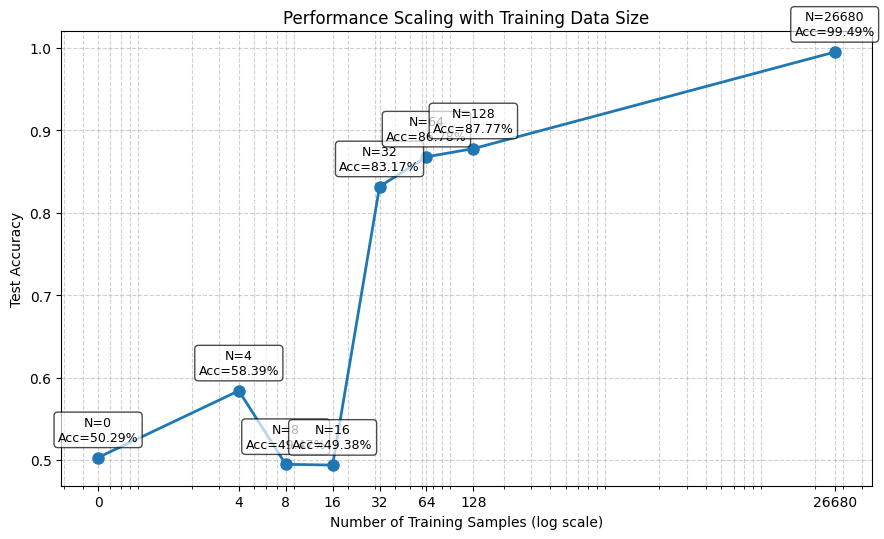

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/working/project_a_scaling_resultsnew.csv")

samples_orig = df["Samples"].values
accuracy = df["Accuracy"].values

x_plot = np.where(samples_orig == 0, 0.5, samples_orig) #modify the 0 to 0.5 for plotting, otherwise may raise error
print("x_plot =", x_plot)  

plt.figure(figsize=(9, 5.5))
plt.plot(x_plot, accuracy, 'o-', linewidth=2, markersize=8, color='tab:blue')

plt.xscale("log")
plt.xlabel("Number of Training Samples (log scale)")
plt.ylabel("Test Accuracy")
plt.title("Performance Scaling with Training Data Size")
plt.grid(True, which="both", ls="--", alpha=0.6)

for i in range(len(df)):
    label_text = f"N={samples_orig[i]}\nAcc={accuracy[i]:.2%}"
    plt.annotate(
        label_text,
        (x_plot[i], accuracy[i]), 
        textcoords="offset points",
        xytext=(0, 12),
        ha='center',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

xticks = [0.5] + sorted([n for n in set(samples_orig) if n > 0])
xtick_labels = ["0"] + [str(n) for n in sorted(set(samples_orig)) if n > 0]
plt.xticks(xticks, xtick_labels)

plt.tight_layout()
plt.savefig("scaling_curve_full.png", dpi=200, bbox_inches='tight')
plt.show()